<a href="https://colab.research.google.com/github/deepaksirohiwal/Deep_Learning_with_PyTorch/blob/main/DeepLearning_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import matplotlib.pyplot as plt

In [36]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Loading dataset
Loading the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.


---

* root: Path where the train/test data is store
* train: Specifies training or test data
* download=True: download the data from the internet if not available at the root
* transform and target_transform : specify the feature and label transformation

In [37]:
training_data= datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data= datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [38]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

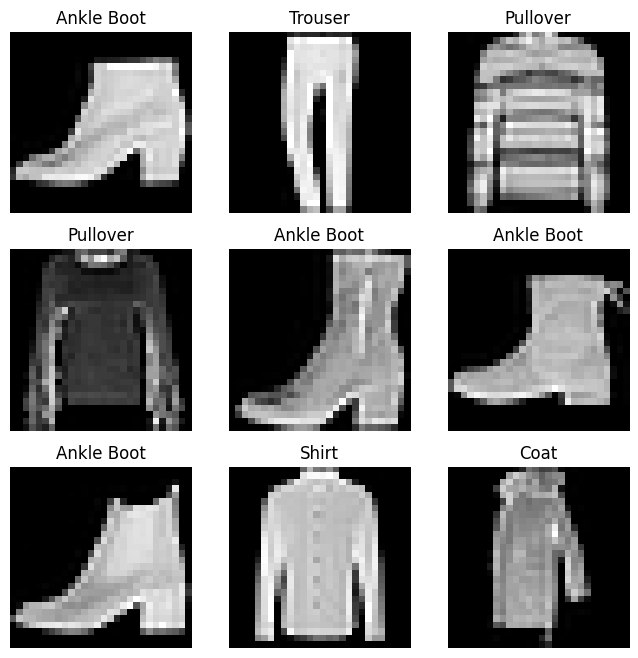

In [39]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [40]:
train_dataloader= DataLoader(training_data, batch_size=64,shuffle=True)
test_dataloader= DataLoader(test_data,batch_size=64, shuffle=True)

In [41]:
next(iter(train_dataloader))[0].size()

torch.Size([64, 1, 28, 28])

Feature batch shape: torch.Size([64, 1, 28, 28])
Lables batch shape: torch.Size([64])


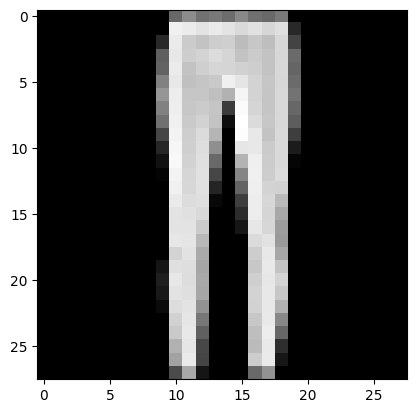

Label: 1


In [42]:
train_features, train_labels= next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Lables batch shape: {train_labels.size()}")
img= train_features[0].squeeze()
label=train_labels[0]
plt.imshow(img,cmap='gray')
plt.show()
print(f"Label: {label}")

## Transform

Data often arrives in forms that might not be immediately suitable for training machine learning algorithms. To prepare such data, we employ transformations that modify it into the required format. For this purpose, TorchVision datasets include two parameters: `transform` and `target_transform`. These parameters accept callable functions that encapsulate the transformation process. The torchvision.transforms module conveniently provides a range of standard transformations.

For instance, in the case of FashionMNIST, the data's features are typically presented as PIL Images, while the labels are represented as integers. However, for effective training, the features need to be normalized tensors, and the labels require one-hot encoding. To perform these essential transformations, we leverage two specific transformations: ToTensor and Lambda.

- **ToTensor**: This transformation converts PIL Images or similar data formats into tensors. It also scales the pixel values to a range between 0 and 1, making the data suitable for neural networks.

- **Lambda**: The Lambda transformation is used to apply custom functions to the data. In this context, it facilitates the conversion of integer labels to one-hot encoded tensors, a necessary step for various classification tasks.

In [43]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

**ToTensor** converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

**Lambda Transforms**

1. **Lambda Transformation**: The `Lambda` transformation is a flexible way to apply custom transformations to the target data. It accepts a callable function and applies it to each target label.

2. **lambda Function**: Inside the `Lambda` transformation, there's a lambda function that takes a label `y` as input.

3. **torch.zeros()**: This creates a tensor of zeros. In this case, it creates a tensor of shape `(10,)` with all values initialized to 0. This tensor will eventually represent the one-hot encoded label.

4. **scatter_()**: The `scatter_` method is a powerful PyTorch function used for in-place modification of the tensor. It allows you to scatter (set) values at specified indices along a given dimension.

5. **dim**: The `dim` parameter specifies the dimension along which the scattering operation is performed. In this case, it's the first dimension (index 0).

6. **index**: The `index` parameter specifies the indices where the value 1 should be placed. The `torch.tensor(y)` is a tensor that holds the original label `y`.

7. **value**: The `value` parameter specifies the value to scatter. In this case, it's 1.

In summary, the code creates a `target_transform` that, when applied to a label `y`, returns a one-hot encoded tensor where the element corresponding to the original label `y` is set to 1, and all other elements are set to 0. The `scatter_` method efficiently achieves this by modifying the existing zero tensor using the index provided by the original label `y`.

For example, if `y` is 3, the corresponding one-hot encoded tensor will be `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`, where the fourth element (index 3) is set to 1, representing the class label 3.

# Building Neural Network


Neural networks are constructed using building blocks known as layers or modules. These modules perform various operations on data. In PyTorch, the `torch.nn` namespace offers a comprehensive set of tools for creating neural networks. Each building block in PyTorch inherits from `nn.Module`, forming a structured foundation for constructing customized neural networks.

In PyTorch, a neural network is essentially a module that encompasses multiple other modules or layers. This hierarchical arrangement simplifies the design and administration of intricate network architectures. Through this nested structure, the process of constructing and controlling complex models becomes more intuitive and manageable.

In [44]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten=nn.Flatten() #convert 28x28 image into a contiguous array of 784 pixel values
    self.linear_relu_stack= nn.Sequential(
        nn.Linear(28*28,512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )
  def forward(self,x):
    x=self.flatten(x)
    logits=self.linear_relu_stack(x)
    return logits

In [45]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Autograd
When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.
To compute those gradients, PyTorch has a built-in differentiation engine called `torch.autograd`. It supports automatic computation of gradient for any computational graph.

To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need derivative of loss w.r.t `w` and `b`  under some fixed values of `x` and `y`. To compute those derivatives, we call `loss.backward()`, and then retrieve the values from `w.grad` and `b.grad`

By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with torch.no_grad() block

```
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)
```

## Hyperparameter
Hyperparameters are tunable settings that provide control over the optimization process of a model. By adjusting these parameters, you can influence the way the model is trained and how quickly it converges to a solution. Effective hyperparameter choices are crucial for achieving optimal model performance.

The following key hyperparameters are defined for the training process:

1. **Number of Epochs**: This determines how many times the entire dataset is iterated through during training. Each epoch allows the model to learn from the entire dataset, potentially improving performance over time.

2. **Batch Size**: The batch size specifies the number of data samples that are processed together in each iteration. It affects the speed and memory efficiency of training. Smaller batch sizes allow more frequent parameter updates, while larger batch sizes can utilize parallelism for faster training.

3. **Learning Rate**: The learning rate controls the step size at which the model's parameters are adjusted during each iteration. A smaller learning rate leads to more cautious updates, potentially yielding more accurate convergence. Conversely, a larger learning rate can speed up training but risks overshooting optimal parameter values.

Optimal hyperparameter settings can lead to faster convergence, better generalization, and improved model performance. Finding the right values often involves experimentation and tuning to achieve the best results for a specific task and dataset.

In [46]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

## Optimization loop
* **Training loop**- iterate over the training dataset and try to converge to optimal parameters.
* **Validation loop**- iterate over the test dataset to check if model performance is improving.

## Optimizer
Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

Inside the training loop, optimization happens in three steps:
* `Call optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

* Backpropagate the prediction loss with a call to `loss.backward()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.

* Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

In [47]:
# Loss function
loss_fn=nn.CrossEntropyLoss()

# Optimizer
optimizer= torch.optim.SGD(model.parameters(), lr=learning_rate)


## Implementation

In [48]:
# training loop
def train_loop(dataloader,model,loss_fn,optimizer):
  size=len(dataloader.dataset)
  # putting in training mode
  model.train()
  for batch, (X,y) in enumerate(dataloader):
    X= X.to(device)
    y= y.to(device)

    pred= model(X)
    loss= loss_fn(pred,y)

    #backpropagation
    # Deposite gradient of the loss w.r.t each parameter
    loss.backward()
    # update the parameters
    optimizer.step()
    # reset the gradiet to zero as by default all the gradient adds up
    optimizer.zero_grad()

    if batch % 100 ==0:
      loss, current=loss.item(), (batch+1)*len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [49]:
# test loop
def test_loop(dataloader,model, loss_fn):
  #setting in evaluation mode
  model.eval()
  size=len(dataloader.dataset)
  num_batches= len(dataloader)
  test_loss, correct=0,0

  # no gradient is going to compute during the evaluation process as we are
  # going to perform the forward pass only
  with torch.no_grad():
    for X,y in dataloader:
      X= X.to(device)
      y= y.to(device)
      pred= model(X)
      test_loss +=loss_fn(pred,y).item()
      correct+=(pred.argmax(1) == y).type(torch.float).sum().item()


  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")




In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.317701 [   64/60000]
loss: 2.299402 [ 6464/60000]
loss: 2.281075 [12864/60000]
loss: 2.266307 [19264/60000]
loss: 2.261525 [25664/60000]
loss: 2.242537 [32064/60000]
loss: 2.226128 [38464/60000]
loss: 2.215008 [44864/60000]
loss: 2.205133 [51264/60000]
loss: 2.165433 [57664/60000]
Test Error: 
 Accuracy: 56.3%, Avg loss: 2.165702 

Epoch 2
-------------------------------
loss: 2.139125 [   64/60000]
loss: 2.151306 [ 6464/60000]
loss: 2.152952 [12864/60000]
loss: 2.084436 [19264/60000]
loss: 2.101016 [25664/60000]
loss: 2.058853 [32064/60000]
loss: 2.044421 [38464/60000]
loss: 1.922346 [44864/60000]
loss: 1.953960 [51264/60000]
loss: 1.910921 [57664/60000]
Test Error: 
 Accuracy: 60.8%, Avg loss: 1.906563 

Epoch 3
-------------------------------
loss: 1.943766 [   64/60000]
loss: 1.811017 [ 6464/60000]
loss: 1.898422 [12864/60000]
loss: 1.789540 [19264/60000]
loss: 1.716891 [25664/60000]
loss: 1.746746 [32064/60000]
loss: 1.611481 [38464/